# CFP Committee Simulator - Composite Rankings

This notebook combines all ranking methods into a composite score

In [1]:
# Cell 1: Merge All Rankings
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# Load individual rankings (from previous notebook outputs)
colley_rankings = pd.read_csv('colley_rankings.csv')
massey_rankings = pd.read_csv('massey_rankings.csv')
elo_rankings = pd.read_csv('elo_rankings.csv')

# Merge all rankings
rankings = colley_rankings[['team', 'colley_rating']].merge(
    massey_rankings[['team', 'massey_rating']], on='team'
).merge(
    elo_rankings[['team', 'elo_rating']], on='team'
)

print(f'Merged rankings for {len(rankings)} teams')
rankings.head()


Merged rankings for 136 teams


,team,colley_rating,massey_rating,elo_rating
0,Notre Dame,0.881386,24.662294,1578.062849
1,James Madison,0.877468,13.060059,1578.809760
2,Alabama,0.863446,14.677100,1552.415758
3,Ohio State,0.857013,30.147924,1580.851835
4,BYU,0.832218,3.964002,1563.930110


In [2]:
# Cell 2: Calculate Win Percentage
def calculate_record(team, games_df):
    """Calculate wins, losses, and win percentage"""
    team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
    
    wins = 0
    losses = 0
    
    for _, game in team_games.iterrows():
        if game['home_team'] == team:
            if game['home_score'] > game['away_score']:
                wins += 1
            else:
                losses += 1
        else:
            if game['away_score'] > game['home_score']:
                wins += 1
            else:
                losses += 1
    
    win_pct = wins / (wins + losses) if (wins + losses) > 0 else 0
    return pd.Series([wins, losses, win_pct])

# Load games data (updated to 2025)
import os
year = 2025  # 2025-2026 season
week = 15

# Try parquet first, fallback to CSV
cache_dir = f'./data/cache/{year}'
parquet_path = f'{cache_dir}/games_w{week}.parquet'
csv_path = f'{cache_dir}/games_w{week}.csv'

if os.path.exists(parquet_path):
    try:
        games_df = pd.read_parquet(parquet_path)
    except (ImportError, ModuleNotFoundError):
        games_df = pd.read_csv(csv_path)
elif os.path.exists(csv_path):
    games_df = pd.read_csv(csv_path)
else:
    raise FileNotFoundError(f"No cached data found. Run notebook 01_data_pipeline.ipynb first.")

print(f"✅ Loaded {len(games_df)} games from cache")

rankings[['wins', 'losses', 'win_pct']] = rankings['team'].apply(
    lambda t: calculate_record(t, games_df)
)

✅ Loaded 557 games from cache


In [3]:
# Cell 3: Calculate Strength of Record (SOR)
def calculate_sor(team, games_df, power_ratings):
    """
    Calculate probability that a top-25 team would achieve same or better record
    """
    team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
    
    wins = 0
    win_probs = []
    
    for _, game in team_games.iterrows():
        if game['home_team'] == team:
            opponent = game['away_team']
            won = game['home_score'] > game['away_score']
            opp_rating = power_ratings.get(opponent, 1500)
            # Top-25 team assumed to have rating of ~1650
            win_prob = 1 / (1 + 10 ** ((opp_rating - 1650) / 400))
        else:
            opponent = game['home_team']
            won = game['away_score'] > game['home_score']
            opp_rating = power_ratings.get(opponent, 1500)
            win_prob = 1 / (1 + 10 ** ((opp_rating + 55 - 1650) / 400))  # +55 for home field
        
        wins += int(won)
        win_probs.append(win_prob)
    
    # Calculate probability of achieving at least this many wins
    expected_wins = sum(win_probs)
    variance = sum(p * (1-p) for p in win_probs)
    
    if variance > 0:
        z_score = (wins - expected_wins) / np.sqrt(variance)
        sor = 1 - stats.norm.cdf(z_score)
    else:
        sor = 0.5
    
    return sor

# Calculate SOR for each team
power_ratings_dict = dict(zip(elo_rankings['team'], elo_rankings['elo_rating']))
rankings['sor'] = rankings['team'].apply(
    lambda t: calculate_sor(t, games_df, power_ratings_dict)
)

In [4]:
# Cell 4: Normalize and Create Composite Score
# Normalize all metrics to 0-1 scale
scaler = MinMaxScaler()
metrics_to_normalize = ['colley_rating', 'massey_rating', 'elo_rating', 'sor', 'win_pct']

normalized_df = rankings.copy()
normalized_df[metrics_to_normalize] = scaler.fit_transform(rankings[metrics_to_normalize])

# Define weights (these can be tuned via backtesting)
weights = {
    'colley_rating': 0.20,
    'massey_rating': 0.25,
    'elo_rating': 0.20,
    'sor': 0.20,
    'win_pct': 0.15
}

# Calculate composite score
normalized_df['composite_score'] = sum(
    normalized_df[metric] * weight 
    for metric, weight in weights.items()
)

# Sort by composite score
final_rankings = normalized_df.sort_values('composite_score', ascending=False).reset_index(drop=True)
final_rankings['rank'] = range(1, len(final_rankings) + 1)

# Save for next notebook
final_rankings.to_csv('final_rankings.csv', index=False)

print('Top 25 Composite Rankings:')
final_rankings[['rank', 'team', 'wins', 'losses', 'composite_score']].head(25)

Top 25 Composite Rankings:


,rank,team,wins,losses,composite_score
0,1,Ohio State,9.0,0.0,0.794053
1,2,Notre Dame,9.0,0.0,0.773057
2,3,Indiana,8.0,0.0,0.756742
3,4,Oregon,7.0,1.0,0.729715
4,5,James Madison,9.0,0.0,0.721999
5,6,Georgia,8.0,1.0,0.693148
6,7,Alabama,7.0,1.0,0.690492
7,8,South Florida,6.0,2.0,0.688712
8,9,North Texas,7.0,1.0,0.685769
9,10,Iowa,5.0,3.0,0.674337


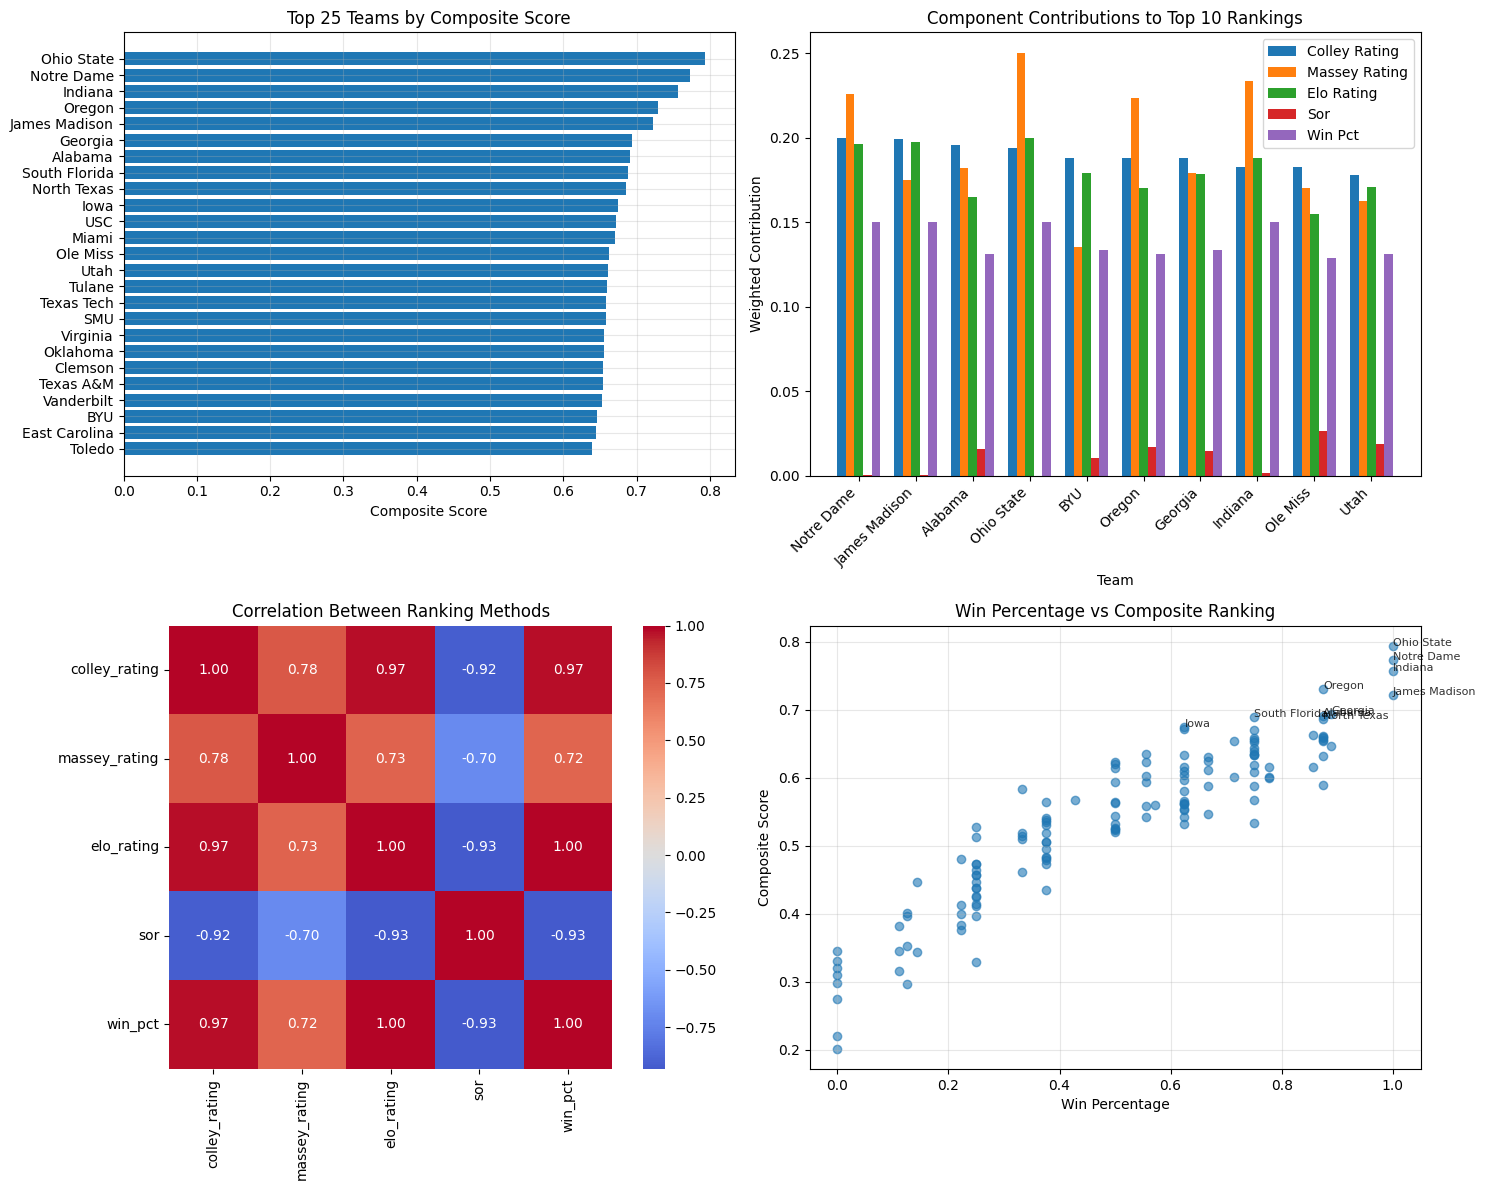

In [5]:
# Cell 5: Visualize Rankings Comparison
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Top 25 composite scores
ax1 = axes[0, 0]
top25 = final_rankings.head(25)
ax1.barh(range(25, 0, -1), top25['composite_score'])
ax1.set_yticks(range(25, 0, -1))
ax1.set_yticklabels(top25['team'])
ax1.set_xlabel('Composite Score')
ax1.set_title('Top 25 Teams by Composite Score')
ax1.grid(True, alpha=0.3)

# Plot 2: Component contributions for top 10
ax2 = axes[0, 1]
top10 = normalized_df.head(10)
components = ['colley_rating', 'massey_rating', 'elo_rating', 'sor', 'win_pct']
x = np.arange(10)
width = 0.15

for i, component in enumerate(components):
    values = top10[component] * weights[component]
    ax2.bar(x + i*width, values, width, label=component.replace('_', ' ').title())

ax2.set_xlabel('Team')
ax2.set_xticks(x + width * 2)
ax2.set_xticklabels(top10['team'], rotation=45, ha='right')
ax2.set_ylabel('Weighted Contribution')
ax2.set_title('Component Contributions to Top 10 Rankings')
ax2.legend()

# Plot 3: Correlation heatmap
ax3 = axes[1, 0]
correlation_matrix = rankings[metrics_to_normalize].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax3, square=True)
ax3.set_title('Correlation Between Ranking Methods')

# Plot 4: Win % vs Composite Score
ax4 = axes[1, 1]
ax4.scatter(final_rankings['win_pct'], final_rankings['composite_score'], alpha=0.6)
for i, row in final_rankings.head(10).iterrows():
    ax4.annotate(row['team'], (row['win_pct'], row['composite_score']), 
                fontsize=8, alpha=0.8)
ax4.set_xlabel('Win Percentage')
ax4.set_ylabel('Composite Score')
ax4.set_title('Win Percentage vs Composite Ranking')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()